# Improving automatic product classification for e-Commerce 

**Oumaima kacem**

**Introduction**

In e-commerce websites , products are usually stored in e-catalogs which is based on the phenomenon of product taxonomies. It is a tree structure that is responsible for allocating the different products in their respective subcategories within categories.

Many comapnies are manually allocating the categories of each item 
therefore this can be unreliable with the increase number of products and subcategories.

In order to scale up, it becomes necessary to automate product recognision . Therefore, deep learning have been suggested in this notebook as a solution to product classification.

**Main contributions**
* e_commerce product classification based on image and text data
* Included image data pre-processing for neural networks and deep learning
* Text preprocessing was performed to get image labels
* Applied transfer learning to get better classification results

**Description of the Dataset**

The data represent 1050 images of products from an online retailer "Flipkart". Each image contains an associated description and is categorized according to a tree system.
The data can be downloaded throughout this site:

https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Textimage+DAS+V2/Dataset+projet+pre%CC%81traitement+textes+images.zip

In [ ]:
from google.colab import drive, files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import keras
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pyplot import imshow
import glob
from sklearn.preprocessing import OneHotEncoder
from time import time
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, History
from keras import regularizers
import keras.backend as K

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('genesis')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
from nltk.stem.porter import *
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.collocations import *
from wordcloud import WordCloud
from IPython.display import display
import base64
import string
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package genesis to /root/nltk_data...
[nltk_data]   Package genesis is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from PIL import Image, ImageOps, ImageFilter
import cv2

In [ ]:
base = pd.read_csv("/content/drive/My Drive/Flipkart/flipkart_com-ecommerce_sample_1050.csv",delimiter = ',',low_memory=False)
print("Dimension de la base: {}".format(base.shape))


Dimension de la base: (1050, 15)


In [ ]:
base.head(2)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [ ]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

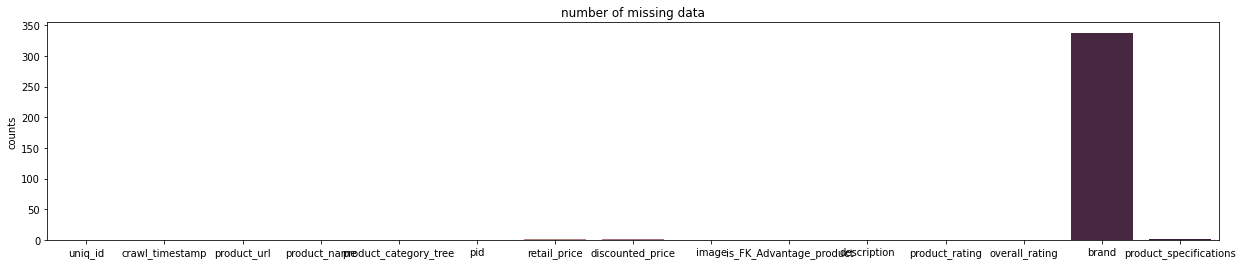

In [ ]:
# Calcul du nombre de valeurs manquantes par colonne
import seaborn as sns
base_missing = base.isna().sum()
# Affichage graphique
fig = plt.figure(1, figsize=(21,4))
sns.barplot(x=base_missing.index, y=base_missing.values,palette="ch:.25")
#plt.xticks(rotation=90)
plt.xlabel("")
plt.ylabel("counts")
plt.title("number of missing data")
plt.show()

In [ ]:
print(base["product_category_tree"][0])

["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]


In [ ]:
# we identify category  and as the depth of subcategories in a product taxonomy
list1, list2 = [], [] 
for categ in base["product_category_tree"] :
    list1.append(categ.split(">>")[0]) 
    list2.append(categ.split(">>")[1]) 

In [ ]:
print("numbre of categories in categ1 {} and in categ2 {} ".format (len(base['categ1'].unique()), len(base['categ2'].unique())))

numbreof categories in categ1 7 and in categ2 63 


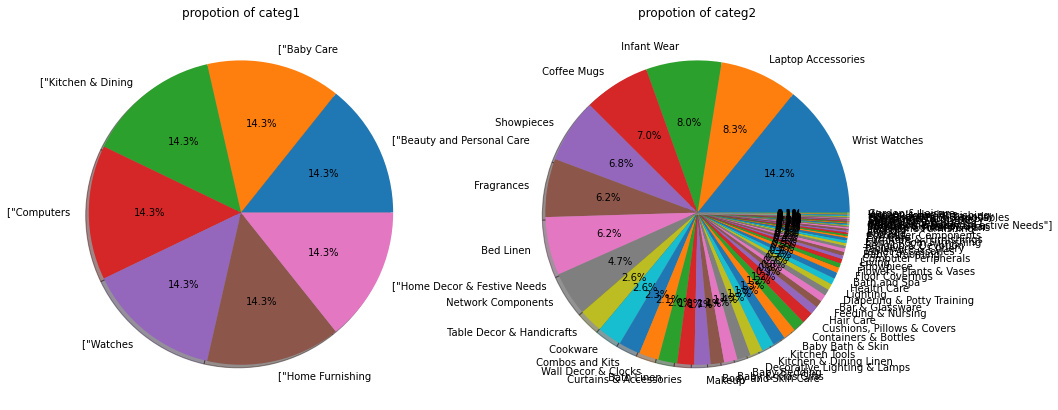

In [ ]:
#Plot counts or poucentages of categories 1 and 2
categories_1 = base["categ1"].value_counts()
categories_2=base['categ2'].value_counts()

fig = plt.figure(1, figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.title("propotion of categ1")
            
plt.pie(categories_1, labels=list(categories_1.index), autopct='%1.1f%%',shadow=True)

plt.subplot(1, 2, 2)
plt.title("propotion of categ2")
            
plt.pie(categories_2, labels=list(categories_2.index), autopct='%1.1f%%',shadow=True)
plt.show()

Since the first level of product tree categories are balanced, we are going to be using that lebel to automate image classification

# Image preprocessing 

For optimal computer vision outcomes, attention to image pre-processing is required so that one can improve image features by eliminating unwanted falsification.

To enhance some image features we applied rectifications to correct the contrast, and we equalized the pictures.


identifiant du produit 64d5d4a258243731dc7bbb1eef49ad74.jpg


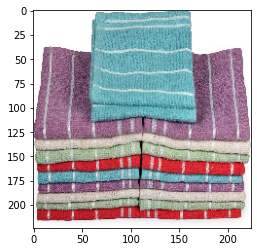

In [ ]:
# load images
images=glob.glob('/content/drive/My Drive/Flipkart/images/*.jpg')
indice=2
print('identifiant du produit', chemin_image)

chemin_image=str(base.loc[indice,'image'])
img = load_img(str("/content/drive/My Drive/Flipkart/images/"+chemin_image), target_size=(224, 224))
imshow(img)


Image contrast enhancement is about identifying  the brightest and darkest tones in the image and attempting  to spread the intermediate tones evenly across this range.
We plot the distribution of pixels based on histograms. Here a Histogram is a grey scale labelled with sliders at each end. By default, the Output sliders are at level 0, where the pixels are black, and level 255, where the pixels are white.

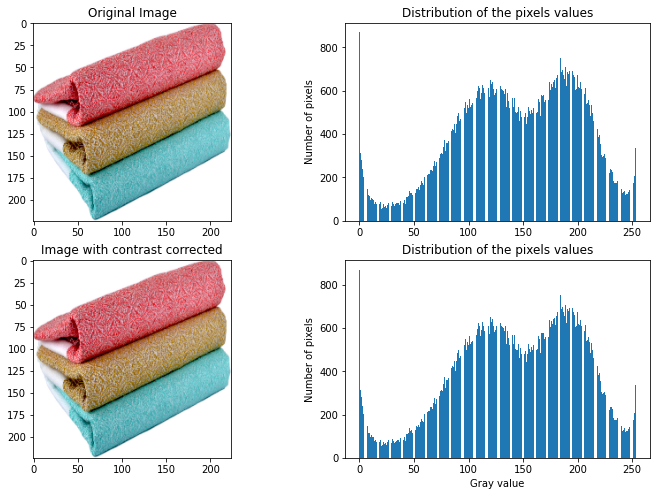

In [ ]:
indice=1
chemin_image=str(base.loc[indice,'image'])
img = load_img(str("/content/drive/My Drive/Flipkart/images/"+chemin_image), target_size=(224, 224))

img_contrast = ImageOps.autocontrast(img)
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(221)
ax1.title.set_text('Original Image')
ax1.imshow(img)

ax2 = fig.add_subplot(222)
ax2.title.set_text('Distribution of the pixels values')
hist, bins = np.histogram(np.array(img).flatten(), bins=255)
ax2 = plt.bar(range(len(hist[0:254])), hist[0:254])
plt.xlabel("")
plt.ylabel("Number of pixels")

ax3 = fig.add_subplot(223)
ax3.title.set_text('Image with contrast corrected')
ax3.imshow(img_contrast)

ax4 = fig.add_subplot(224)
ax4.title.set_text('Distribution of the pixels values')
hist, bins = np.histogram(np.array(img_contrast).flatten(), bins=255)
ax4 = plt.bar(range(len(hist[0:254])), hist[0:254])
plt.xlabel("Gray value")
plt.ylabel("Number of pixels")
plt.show()


The histogram equalization allows to better distribute the intensities over the whole range of possible values, by stretching the histogram.
This allows for areas of lower local contrast to gain a higher contrast. therefore gain on the global contrast.

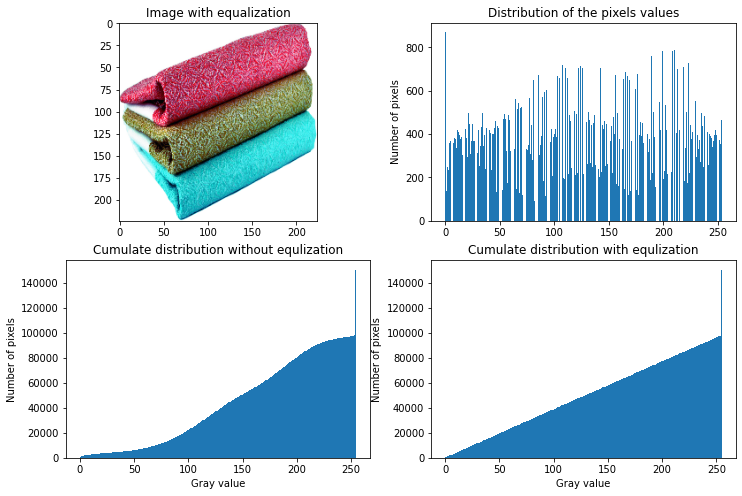

In [ ]:
img_equalized = ImageOps.equalize(img_contrast)

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(221)
ax1.title.set_text('Image with equalization')
ax1.imshow(img_equalized)

ax2 = fig.add_subplot(222)
ax2.title.set_text('Distribution of the pixels values')
hist, bins = np.histogram(np.array(img_equalized).flatten(), bins=255)
ax2 = plt.bar(range(len(hist[0:254])), hist[0:254])
plt.xlabel("")
plt.ylabel("Number of pixels")

ax3 = fig.add_subplot(223)
ax3.title.set_text('Cumulate distribution without equlization')
ax3.hist(np.array(img_contrast).flatten(), bins=255, cumulative=True)
plt.xlabel("Gray value")
plt.ylabel("Number of pixels")

ax4 = fig.add_subplot(224)
ax4.title.set_text('Cumulate distribution with equlization')
ax4.hist(np.array(img_equalized).flatten(), bins=255, cumulative=True)
plt.xlabel("Gray value")
plt.ylabel("Number of pixels")
plt.show()

In [ ]:
 # we automatize image preprocessing on all our data
for indice in range(0,800): 
    chemin_image=str(base.loc[indice,'image'])
    img = load_img(str("/content/drive/My Drive/Flipkart/images/"+chemin_image), target_size=(224, 224))
    img = ImageOps.autocontrast(img)
    img = ImageOps.equalize(img)
    img = img_to_array(img)
    img = preprocess_input(img) 
    images[indice]=img
    images = np.ndarray(shape)

shape =(800,img.shape[0], img.shape[1], img.shape[2])
images = np.ndarray(shape)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


In [ ]:
images.shape

(1050, 224, 224, 3)

# Text preprocessing

In [ ]:
try:
    stopwords = set(stopwords.words('english') )
except LookupError:
    import nltk
    nltk.download('stopwords')
    stopwords = set(stopwords.words('english'))

stemmer = SnowballStemmer("english")


In [ ]:
def normalise2(texte):
    tokenizer = nltk.RegexpTokenizer(r'\w+')
    liste0=word_tokenize(texte.lower())
    liste1 = [w.lower() for w in liste0 if w not in stopwords and w.isalpha()]
    lemmatizer = WordNetLemmatizer() 
    liste2=[ stemmer.stem(lemmatizer.lemmatize(x)) for x in liste1]    
    return liste2


In [ ]:
tokenizer=nltk.RegexpTokenizer(r'\w+')
liste0=word_tokenize(base['product_category_tree'][200].lower())
liste1=[w.lower() for w in liste0 if w not in stopwords and w.isalpha()]
lemmatizer = WordNetLemmatizer() 
[ stemmer.stem(lemmatizer.lemmatize(x)) for x in liste1]  

['home', 'decor', 'festiv', 'need', 'showpiec', 'design', 'hut', 'showpiec']

In [ ]:
liste0=tokenizer.tokenize(base['product_category_tree'][200].lower())
[w.lower() for w in liste0 if w not in stopwords and w.isalpha()]

['home',
 'decor',
 'festive',
 'needs',
 'showpieces',
 'design',
 'hut',
 'showpieces']

In [ ]:
print(base['product_category_tree'][200])
print(normalise2(base['product_category_tree'][200]))

["Home Decor & Festive Needs >> Showpieces >> MA Design Hut Showpieces"]
['home', 'decor', 'festiv', 'need', 'showpiec', 'design', 'hut', 'showpiec']


In [ ]:
liste_category=[]
for i in base.index:
    liste_category.append(normalise2(base.loc[i,'product_category_tree'])[0])
liste_category=list(set(liste_category))
print(liste_category)
nb_categ=len(liste_category)
dh=pd.DataFrame()
for i in base.index:
    dh.loc[i,'nom']=base.loc[i,'product_name']
    dh.loc[i,'target']=normalise2(base.loc[i,'product_category_tree'])[0]

print(nb_categ)


['home', 'watch', 'comput', 'babi', 'kitchen', 'beauti']
6


# Labeling images

In [ ]:
After preprocessing text data, we start labeling our images 

In [ ]:
targ=dh['target'][0:800]
y=[]
for i in range(0,800):
    
    if targ[i]=="home" :
        y.append(0)

    elif targ[i]=="babi" :
        y.append(1)
    elif targ[i]=="watch" :
        y.append(2)
    elif targ[i]=="kitchen" :
        y.append(3)
    elif targ[i]=="comput" :
        y.append(4)
    elif targ[i]=="beauti" :
        y.append(5)

y = np.asarray(y).reshape(-1, 1)
y.shape


(800, 1)

In [ ]:
#one hot encoder
enc = OneHotEncoder(sparse=False)
y_onehot = enc.fit_transform(y)
y_onehot.shape

(800, 6)

# Transfer Learning for image classification 

Transfer learning is a research problem in machine learning that focuses on reusing a previously gained knowledge while solving one problem and applying it to a different but related problem.

VGG-16 consists of several layers, including 13 convolution layers and 3 fully-connected layers. It must therefore learn the weights of 16 layers. It was used to win ILSVR(Imagenet) competition in 2014


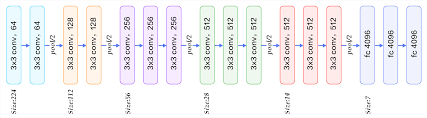

In [5]:
from IPython.display import Image
Image(filename='vgg16.png') 



It takes as input a color image of size 224 × 224 px and classifies it in one of 1000 classes. It returns a vector of size 1000, which contains the probabilities of belonging to each of the classes. 

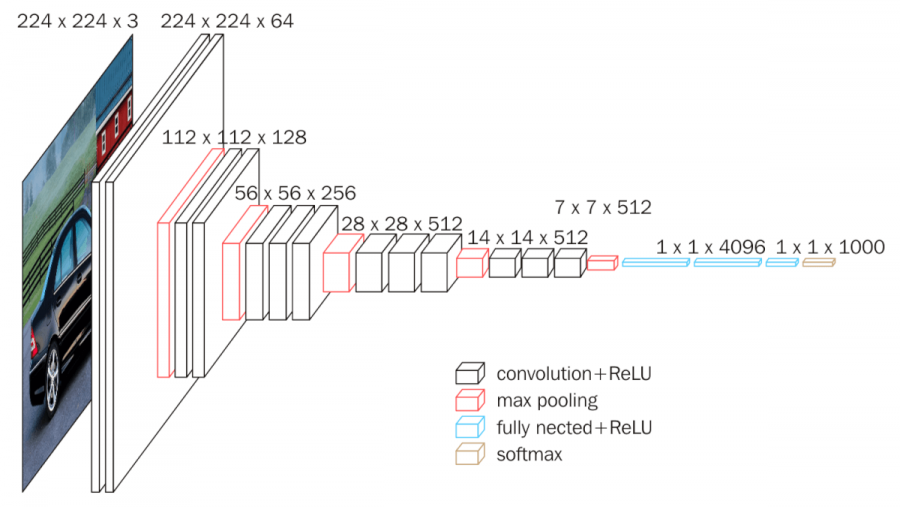

In [4]:
Image(filename='vgg16-1.png')

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.layers import Dense
from keras.models import Model
from keras import optimizers
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D

def build_model():
  model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
  for layer in model.layers:
    layer.trainable = False
  x = model.output
  x=Flatten()(x) 
  
  predictions = Dense(6, activation='softmax')(x)
  new_model = Model(inputs=model.input, outputs=predictions)
  return new_model

new_model=build_model()
new_model.summary()


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images,y_onehot,stratify=y_onehot,test_size=0.2)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(y_test.shape)
print(X_test.shape)

(640, 224, 224, 3)
(640, 6)
(160, 6)
(160, 224, 224, 3)


In [ ]:
checkpoints_path='/content/drive/My Drive/Flipkart/checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5'
reg = regularizers.l1_l2(l1=0.001, l2=0.00)

In [ ]:
# compile the model before fitting 
optimizer= optimizers.Adam(lr=1e-3)
#checkpoint of the model (based on val_loss)
checkpoint = ModelCheckpoint(checkpoints_path, verbose=1, save_weights_only=True, save_best_only=True)
#early stopping
earlyStopping = EarlyStopping(patience = 30, verbose=1)
#learning rate reduction
reducelr = ReduceLROnPlateau(verbose = 1, patience= 10)
#terminating on NaN loss values
nanStopping = TerminateOnNaN()
#callbacks
callbacks_list = [checkpoint, earlyStopping,nanStopping]

new_model.compile(optimizer=optimizer, loss="mean_squared_error", metrics=["accuracy"])


we split our data set in two parts. One is used to learn the features of the pictures and categories. The We take 80% of the data for the training test and 20% for the testing. We use the stratified kfold on the category column to keep a minimum amount of images in each set.

In [ ]:
batch =  int(X_train.shape[0] / 100)
info =new_model.fit(X_train, y_train, epochs=150,batch_size=batch, verbose=2, validation_data=(X_test, y_test))

7/7 [==============================] - 3s 273ms/step - loss: 1.2816 - accuracy: 0.5619
Test accuracy: 0.561904788017273
Test loss: 1.2815955877304077


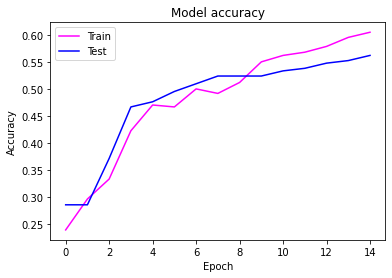

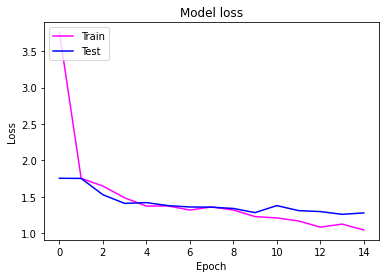

In [ ]:
# evaluating the performance of the model on test data
test_loss, test_acc = new_model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

# Plot training & validation accuracy values
plt.plot(info.history['accuracy'],color='magenta')
plt.plot(info.history['val_accuracy'],color='blue')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(info.history['loss'],color='magenta')
plt.plot(info.history['val_loss'],color='blue')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    import itertools    

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[46  3  4  1  2  4]
 [18  4  3  0  0  5]
 [ 4  0 25  0  0  1]
 [ 6  0  0 18  3  3]
 [12  1  0  1 13  3]
 [16  2  0  0  0 12]]


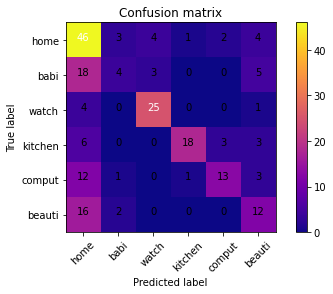

In [ ]:
y_pred= new_model.predict_on_batch(X_test)
y_pred1= np.argmax(y_pred,axis=1)
y_test1=np.argmax(y_test, axis=1)
# confusion matrix display
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test1, y_pred1)
cm_plot_labels= ["home","babi","watch","kitchen","comput","beauti"]
plot_confusion_matrix(cm,classes= cm_plot_labels,title='Confusion matrix',cmap='plasma')